# PCA 

## Time to get your hands dirty. The HR diagram

This assignment is about stars...

We will work with a star catalogue of 240 stars described by the following information:

- Temperature (in Kelvin)
- Luminosity (L/Lo)
- Radius (R/Ro)
- Absolute magnitude (Mv)

We also have the following data for each star:

- Color (Red/Orange/Yellow/White/Blue)
- Spectral class ('A', 'B', 'F', 'G', 'K', 'M', 'O')
- Star type (Brown dwarf/Red dwarf/White dwarf/Main sequence/Supergiant/Hypergiant)

This dataset has been collected by [Deepraj Baidya](https://github.com/deepraj1729) and was originally published on [Kaggle](https://www.kaggle.com/deepu1109/star-dataset). 

There are 6 star types that are encoded in the *'Star type'* column. These labels are currently encoded as strings which is practical for reading but not for computing. Using scikit-learn, we will convert this column into integers by assigning a unique int value to each star type.

We've seen this already last time. It is often grood practice to start with a statistical analysis of the dataset to answer the following questions:
* are there any missing values?
* are there NaNs in the data?

Star classification is something that can be done based on rules depending on temperature and luminosity. We can reproduce this diagram by plotting the scatter plot of our stars using the same variables in log-log-scale.

We find the same organization of stars in this 2D plane. Main Sequence stars and White Dwarves are fairly easy to isolate from the rest: a statistical model should be able to easily classify them. Based only on Luminosity and Temperature, Dwarf stars and Giant stars have higher intra-group variability: Supergiant and Hypergiant cover the same space (same for Brown and Red Dwarves). Additionnal variables might be needed to correctly identify the types of those stars.

- Apply PCA to the dataset at your disposal (hint: don't use columns with labels, only those with real numbers).
- Project the dataset into the principal components, and do a scatter plot of the first two. 
- This will look terrible. Think about the units!
- Explore what happens if you rescale the data first.

**This is actually a very important lesson in machine learning**: Massaging your data before giving them to an algorithm can make things much much better.

- You can try an linear, affine transformation such that each dimension goes between -1 and 1.
- Or (which is [the usual machine-learning approach](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)) standardize your data such that each dimension has mean=0 and variance=1. 
- Redo your PCA. Should be much much better.
- How much variance is explained by those two components?



### For later: come back to this assignment after lecture 20
- Now run a supervised classification algorithm on this dataset. 
- Can you predict the stellar type? How well? Careful with overfitting of course.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from astropy import constants as const
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline

Load the dataset and look at it, then assign the labels (numbers) at the star types

In [2]:
# If they are useful
M_sun = const.M_sun
R_sun = const.R_sun
L_sun = const.L_sun

# Download the data
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")
df_stars = pd.read_csv("stars.csv")
print(df_stars)

# Actually, the dataset seems clean.
df_stars.info()

le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels = le.inverse_transform(df_stars['Star type'])
class_names = le.classes_
print(class_names)
#print(df_stars['Star type'])

     Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
0               3068          0.002400        0.1700                   16.12   
1               3042          0.000500        0.1542                   16.60   
2               2600          0.000300        0.1020                   18.70   
3               2800          0.000200        0.1600                   16.65   
4               1939          0.000138        0.1030                   20.06   
..               ...               ...           ...                     ...   
235            38940     374830.000000     1356.0000                   -9.93   
236            30839     834042.000000     1194.0000                  -10.63   
237             8829     537493.000000     1423.0000                  -10.73   
238             9235     404940.000000     1112.0000                  -11.23   
239            37882     294903.000000     1783.0000                   -7.80   

       Star type Star color Spectral Cl

Now I plot the HR diagram with the classified stars

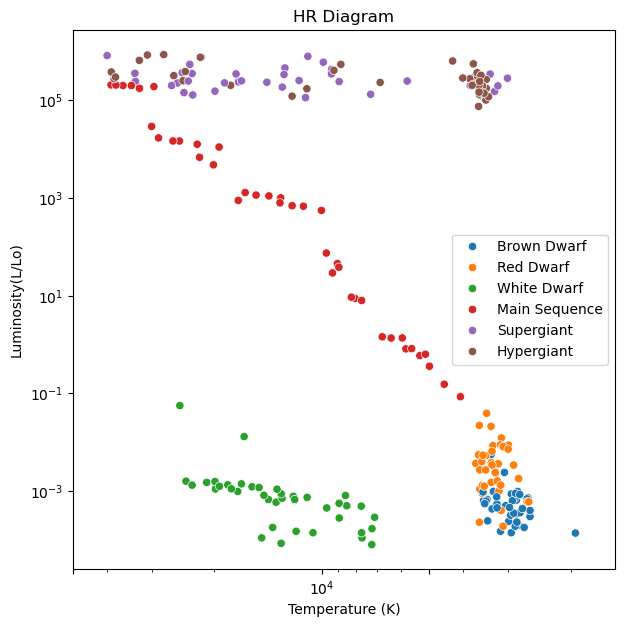

In [3]:
# Plotting HR diagram with the classification from the Data
fig = plt.figure(figsize=(7, 7))
sns.scatterplot(data = df_stars, x = 'Temperature (K)', y = 'Luminosity(L/Lo)', hue = labels)

plt.xscale('log')
plt.yscale('log')
plt.title('HR Diagram')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

## Unrefined PCA

Here I apply the PCA without rescaling the dataset

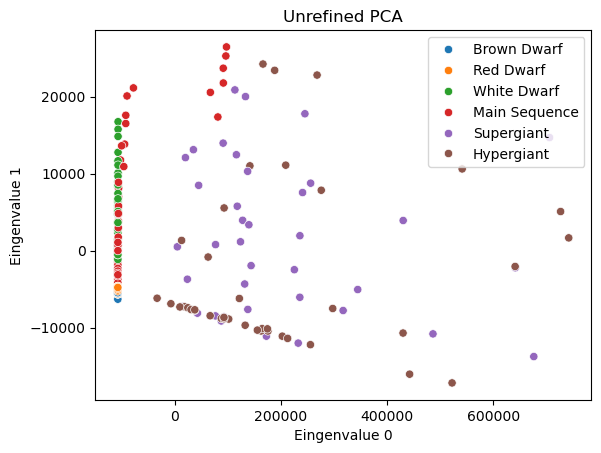

In [4]:
pca_data = df_stars[['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']]

# Aplly PCA and get the data in the new frame
pca = PCA(n_components = 2) 
pca.fit(pca_data)
pca_features = pca.transform(pca_data)

sns.scatterplot(x = pca_features[:, 0], y = pca_features[:,1], hue = labels)
plt.title('Unrefined PCA')
plt.xlabel('Eingenvalue 0')
plt.ylabel('Eingenvalue 1')
plt.show()

In [5]:
print(pca_data.shape)

(240, 4)


The result is a mess, this could be a problem of standardization.

I try to plot the explained variance for the components and their different importance for each new feature; if there is a problem due to explained variance, I should see that some component is much more important than the others. I can do histograms for example

[[ 2.09892192e-02  9.99778551e-01  1.51672530e-03 -4.06568779e-05]
 [ 9.99737574e-01 -2.09743948e-02 -9.20988063e-03 -1.91786135e-04]]


Text(0.5, 1.0, 'Components Imporance')

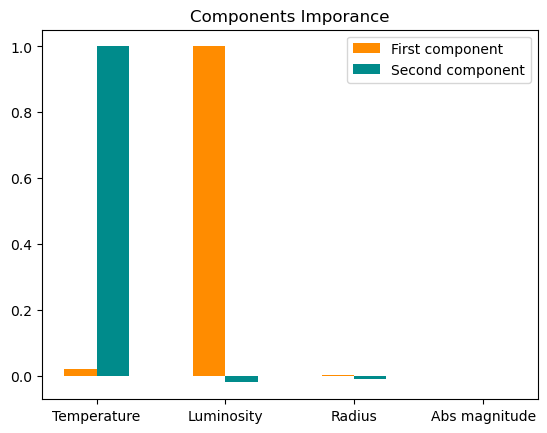

In [6]:
names = ['Temperature', 'Luminosity', 'Radius', 'Abs magnitude']
print(pca.components_)
x = np.arange(len(names))

plt.bar(x, pca.components_[0], width = 0.25, color = 'darkorange', label = 'First component')
plt.bar(x + 0.25, pca.components_[1], width = 0.25, color = 'darkcyan', label = 'Second component')
plt.legend()
plt.xticks(x + 0.25/2, names)
plt.title('Components Imporance')

Here you see that in the first component almost all the weight is given to the Luminosity, instead in the second one is all on the temperature; let's scale the data and see what happens at the same plot

## Refined PCA

Centering and whitening the data using a standard algorithm from sklearn

In [7]:
scaler = StandardScaler()
pca_scaled_data = scaler.fit_transform(pca_data)

In [8]:
pca_s = PCA(n_components = 2) 
final_pca_features = pca_s.fit_transform(pca_scaled_data)

Now I look at the importance of the different compoents after the rescaling

[[-0.35018343 -0.55933789 -0.47477107  0.58232734]
 [ 0.82161262  0.00452564 -0.56898115  0.03453503]]


Text(0.5, 1.0, 'Components Imporance')

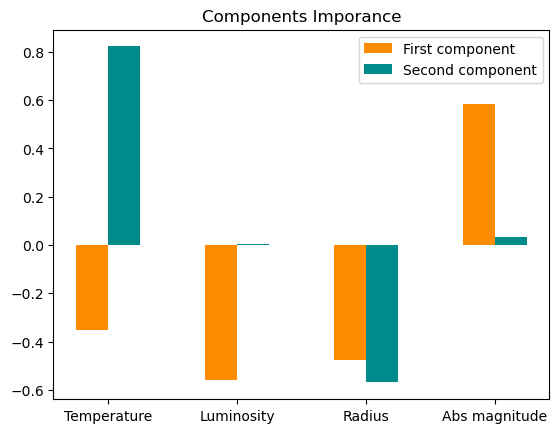

In [9]:
names = ['Temperature', 'Luminosity', 'Radius', 'Abs magnitude']
print(pca_s.components_)
x = np.arange(len(names))

plt.bar(x, pca_s.components_[0], width = 0.25, color = 'darkorange', label = 'First component')
plt.bar(x + 0.25, pca_s.components_[1], width = 0.25, color = 'darkcyan', label = 'Second component')
plt.legend()
plt.xticks(x + 0.25/2, names)
plt.title('Components Imporance')

The weights there seems much better distributed than before, now look at the plot of the eigenvalues

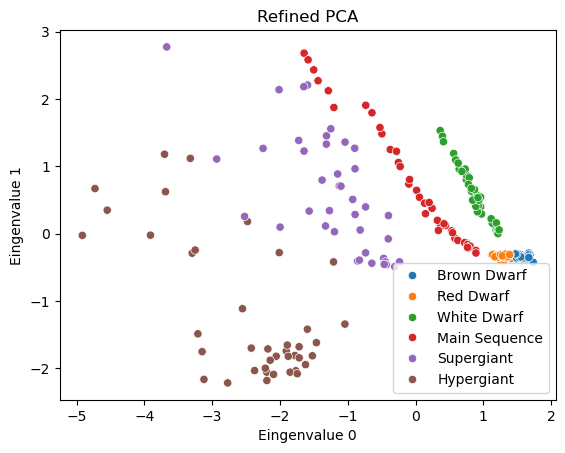

In [10]:
sns.scatterplot(x = final_pca_features[:, 0], y = final_pca_features[:,1], hue = labels)
plt.title('Refined PCA')
plt.xlabel('Eingenvalue 0')
plt.ylabel('Eingenvalue 1')
plt.show()

The result is much better! 

Now I look at how the variance is explained by each component with the scree plot

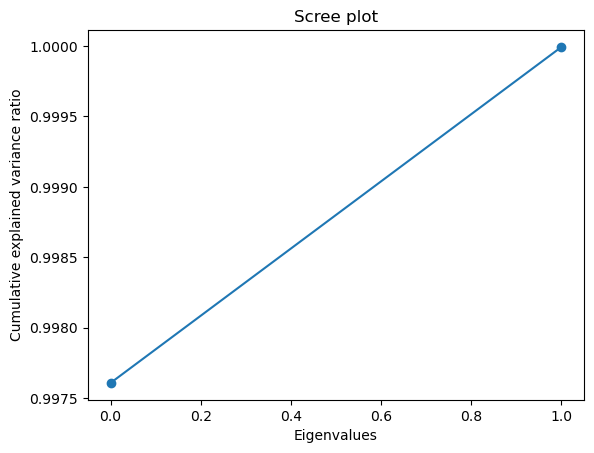

In [11]:
# Scree plot
evals = pca.explained_variance_ratio_ 
plt.title('Scree plot')
plt.xlabel('Eigenvalues')
plt.ylabel('Cumulative explained variance ratio')
plt.plot(evals.cumsum(), marker = 'o')
plt.show()

In this case, adding more components would be better because there is a lot of unexplained variance here. Let's try with the full component set (4 components)

In [12]:
pca = PCA(n_components = 4) 
final_pca_features = pca.fit_transform(pca_scaled_data)

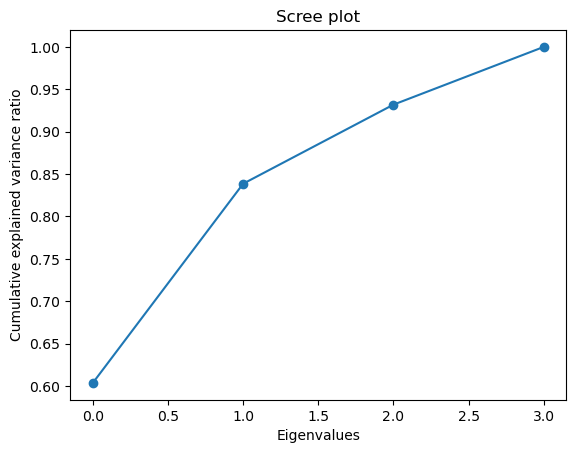

In [13]:
# Scree plot
evals = pca.explained_variance_ratio_ 
plt.title('Scree plot')
plt.xlabel('Eigenvalues')
plt.ylabel('Cumulative explained variance ratio')
plt.plot(evals.cumsum(), marker = 'o')
plt.show()

# Classification algorithm

As suggested, I try to apply a classification algorithm to learn and predict the stellar types.
I try two different situations and compare them: 
- Classification without PCA
- Classification after PCA

I think KNN is not the best for classification here: the 'blobs' looks a bit elongated in defined directions and in general, KNN tecquinques are better for 'spherical' clusters.
I try with DTC classifier

In [14]:
import sklearn.metrics as skm

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from astroML.utils import completeness_contamination
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

## Plain classification

Splitting for CV, training and test

In [15]:
x_train, x_test, y_train, y_test = train_test_split(pca_data, df_stars['Star type'], test_size=0.2, random_state=42)
cv_x, x_train, cv_y, y_train =  train_test_split(x_train, y_train, test_size=0.3, random_state=42)

In [16]:
def RMS (X, Y, func):

    return np.sqrt( np.sum(( Y - func.predict(X))**2) / len(X))

In [17]:
depth = np.linspace(1, 11, 10, dtype = int)
scores_cv = []
scores_train = []

cv_x, cv_y = shuffle(cv_x, cv_y)

for i in depth:
    
    clf = DecisionTreeClassifier(max_depth = i, random_state = 0)
    clf.fit(cv_x, cv_y)
    
    cv_results = cross_validate(clf, cv_x, cv_y, cv = 5, scoring = 'accuracy', return_train_score = True)
    scores_cv.append(np.mean(cv_results['test_score']))
    scores_train.append(np.average(cv_results['train_score']))


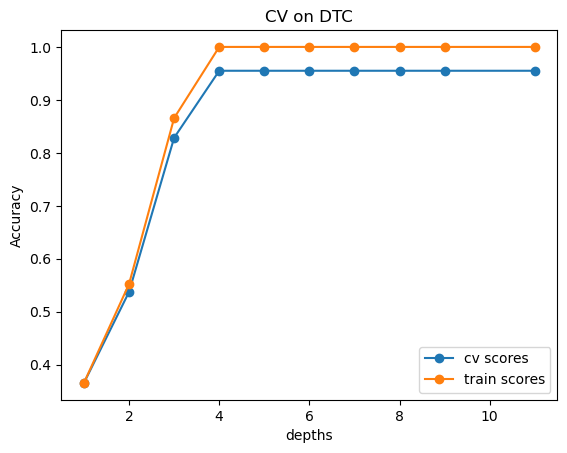

In [18]:
plt.plot(depth, scores_cv, marker = 'o', label = 'cv scores')
plt.plot(depth, scores_train, marker = 'o', label = 'train scores')
plt.title('CV on DTC')
plt.xlabel('depths')
plt.ylabel('Accuracy')
#plt.yscale('log')
plt.legend()

I'll pick depth = 4 as the maximum depth of the tree.

Now I can go on training the DT

In [19]:
DTC = DecisionTreeClassifier(max_depth = 4, random_state = 0)
DTC.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

Look at the goodness of classification

Completness (TPR): 0.789
Contamination: 0.062
Efficiency: 0.938
Accuracy: 0.792




Text(0.5, 23.52222222222222, 'Predicted label')

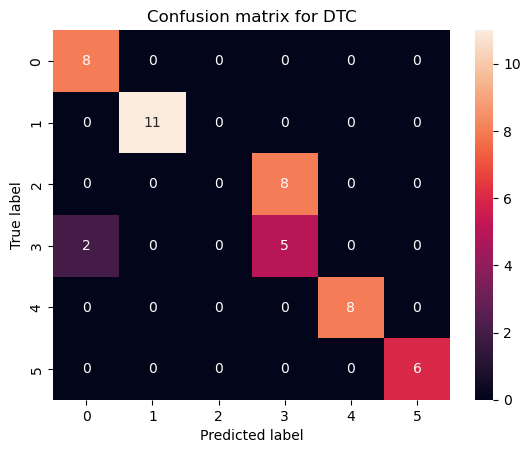

In [20]:
y_pred = DTC.predict(x_test)
comp, cont = completeness_contamination(y_test, y_pred)
print('Completness (TPR): %.03f' %comp)
print('Contamination: %.03f' %cont)
print('Efficiency: %.03f' %(1 - cont))
print('Accuracy: %.03f' %skm.accuracy_score(y_test, y_pred))

print('\n')

sns.heatmap(skm.confusion_matrix(y_test, y_pred), annot = True, fmt="d")
plt.title('Confusion matrix for DTC')
plt.ylabel('True label')
plt.xlabel('Predicted label')

I compare the two plots: the true labels with the classified ones. I can see from the plot of the predicted labels that the algorithm classifies only 5 labels out of 6! Maybe More data are needed to discriminate better.

The problematic labels are the one on the MS of the HR diagram, maybe with a PCA things are better separeted and better classified

/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_54369/2187707121.py:15: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  sns.scatterplot(x_test, x = 'Temperature (K)', y = 'Luminosity(L/Lo)', hue = inv_predictions, palette = sns.color_palette("husl", 9) )#sns.color_palette())


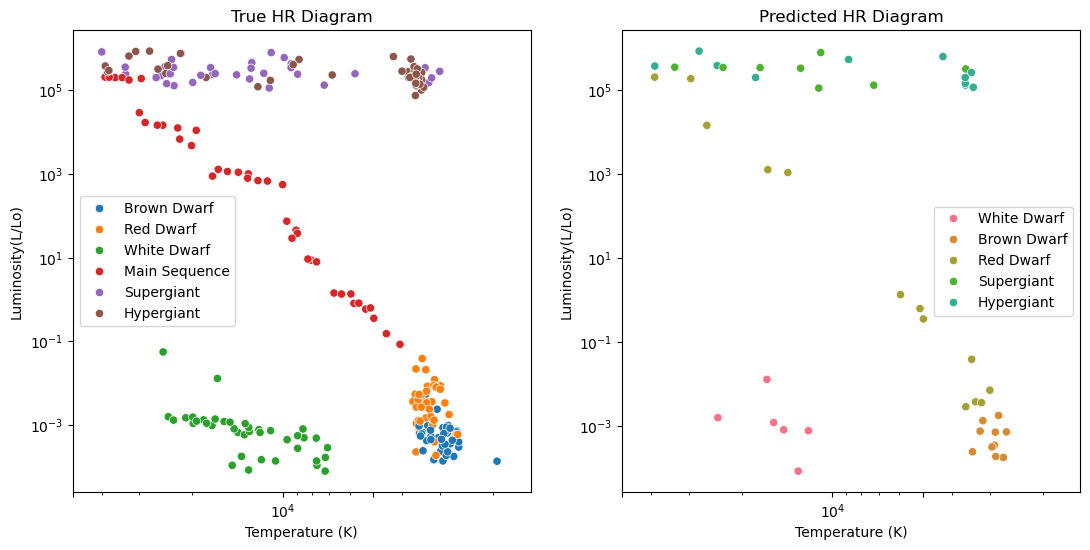

In [21]:
fig = plt.figure(figsize=(13, 6))

ax = plt.subplot(121)
sns.scatterplot(data = df_stars, x = 'Temperature (K)', y = 'Luminosity(L/Lo)', hue = labels)

plt.xscale('log')
plt.yscale('log')
plt.title('True HR Diagram')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)

inv_predictions = le.inverse_transform(y_pred)

ax = plt.subplot(122)
sns.scatterplot(x_test, x = 'Temperature (K)', y = 'Luminosity(L/Lo)', hue = inv_predictions, palette = sns.color_palette("husl", 9) )#sns.color_palette())

plt.xscale('log')
plt.yscale('log')
plt.title('Predicted HR Diagram')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)

plt.show()

## Post-PCA classification

In [35]:
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(pca_features, df_stars['Star type'], test_size=0.2, random_state=42)
cv_x_pca, x_train_pca, cv_y_pca, y_train_pca =  train_test_split(x_train_pca, y_train_pca, test_size=0.3, random_state=42)

### Using Accuracy as CV

The accuracy is preferred because it's the method used in the training by the classifier

In [36]:
depth = np.linspace(1, 11, 10, dtype = int)
scores_cv_pca = []
scores_train_pca = []

cv_x_pca, cv_y_pca = shuffle(cv_x_pca, cv_y_pca)

for i in depth:
    
    clf = DecisionTreeClassifier(max_depth = i, random_state = 0)
    clf.fit(cv_x_pca, cv_y_pca)
    #scores_cv.append(- np.mean(cross_val_score(clf, cv_x, cv_y, cv = 5, scoring = 'top_k_accuracy')))
    cv_results_pca = cross_validate(clf, cv_x_pca, cv_y_pca, cv = 5, scoring = 'accuracy', return_train_score = True)
    scores_cv_pca.append(np.mean(cv_results_pca['test_score']))
    scores_train_pca.append(np.mean(cv_results_pca['train_score']))


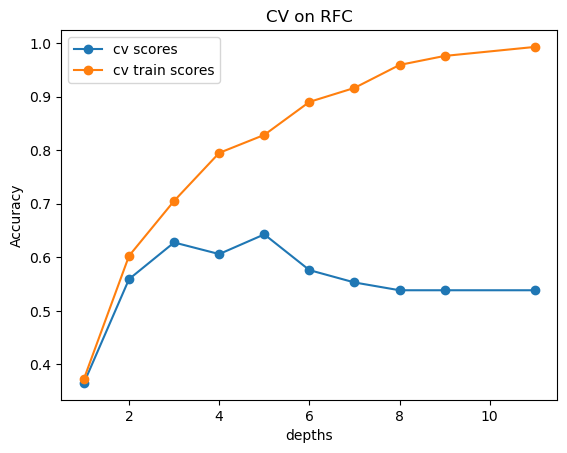

In [37]:
plt.plot(depth, scores_cv_pca, marker = 'o', label = 'cv scores')
plt.plot(depth, scores_train_pca, marker = 'o', label = 'cv train scores')
plt.title('CV on RFC')
plt.xlabel('depths')
plt.ylabel('Accuracy')
#plt.yscale('log')
plt.legend()

### Using RMS as CV

In [38]:
depth = np.linspace(1, 11, 10, dtype = int)
scores_cv_pca = []
scores_train_pca = []

cv_x_pca, cv_y_pca = shuffle(cv_x_pca, cv_y_pca)

for i in depth:
    
    clf = DecisionTreeClassifier(max_depth = i, random_state = 0)
    clf.fit(cv_x_pca, cv_y_pca)

    cv_results_pca = cross_validate(clf, cv_x_pca, cv_y_pca, cv = 5, scoring = 'neg_root_mean_squared_error', return_train_score = True)
    scores_cv_pca.append(-np.mean(cv_results_pca['test_score']))
    scores_train_pca.append(-np.mean(cv_results_pca['train_score']))



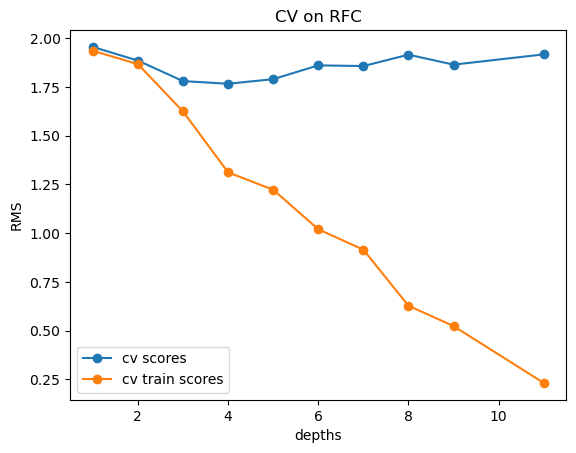

In [39]:
plt.plot(depth, scores_cv_pca, marker = 'o', label = 'cv scores')
plt.plot(depth, scores_train_pca, marker = 'o', label = 'cv train scores')
plt.title('CV on RFC')
plt.xlabel('depths')
plt.ylabel('RMS')
#plt.yscale('log')
plt.legend()

depth = 3 seems the best one without overfitting!

In [40]:
DTC_pca = DecisionTreeClassifier(max_depth = 3, random_state = 0)
DTC_pca.fit(x_train_pca, y_train_pca)

DecisionTreeClassifier(max_depth=3, random_state=0)

Completness (TPR): 0.600
Contamination: 0.077
Efficiency: 0.923
Accuracy: 0.625




Text(0.5, 23.52222222222222, 'Predicted label')

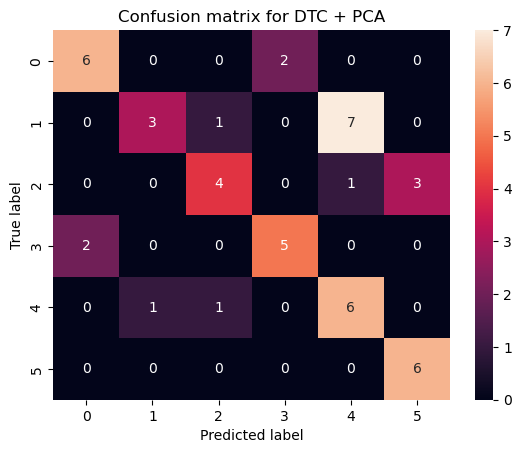

In [41]:
y_pred_pca = DTC_pca.predict(x_test_pca)
comp_pca, cont_pca = completeness_contamination(y_test_pca, y_pred_pca)
print('Completness (TPR): %.03f' %comp_pca)
print('Contamination: %.03f' %cont_pca)
print('Efficiency: %.03f' %(1 - cont_pca))
print('Accuracy: %.03f' %skm.accuracy_score(y_test_pca, y_pred_pca))

print('\n')

sns.heatmap(skm.confusion_matrix(y_test_pca, y_pred_pca), annot = True, fmt="d")
plt.title('Confusion matrix for DTC + PCA')
plt.ylabel('True label')
plt.xlabel('Predicted label')

/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_54369/612780368.py:14: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  sns.scatterplot(x_test, x = 'Temperature (K)', y = 'Luminosity(L/Lo)', hue = inv_predictions_pca, palette = sns.color_palette("husl", 9) )#sns.color_palette())


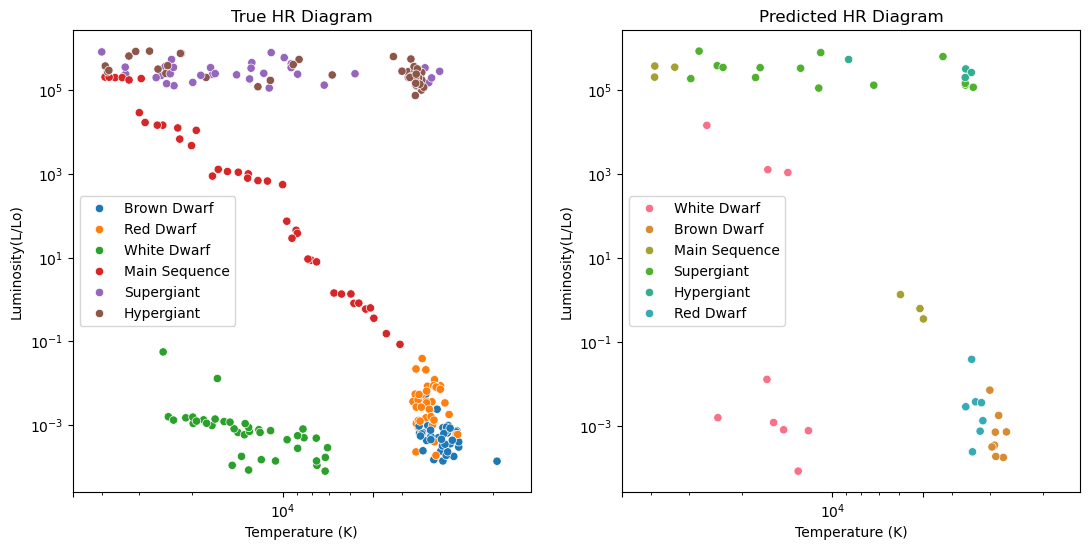

In [44]:
fig = plt.figure(figsize=(13, 6))

ax = plt.subplot(121)
sns.scatterplot(data = df_stars, x = 'Temperature (K)', y = 'Luminosity(L/Lo)', hue = labels)

plt.xscale('log')
plt.yscale('log')
plt.title('True HR Diagram')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)

inv_predictions_pca = le.inverse_transform(y_pred_pca)
ax = plt.subplot(122)
sns.scatterplot(x_test, x = 'Temperature (K)', y = 'Luminosity(L/Lo)', hue = inv_predictions_pca, palette = sns.color_palette("husl", 9) )#sns.color_palette())

plt.xscale('log')
plt.yscale('log')
plt.title('Predicted HR Diagram')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)

plt.show()

The parameters of the classification are wrost than the ones with the full dataset, but at least thanks to PCA I identified all the stellar types in the dataset.

To improve the result, I could use a different tecnique than PCA (t-SNE or Isomap for example), look if the separation between the classes is better than what PCA does and then try a classifier. Also having more data could help.